In [ ]:
# Install the required libraries
!pip install prophet
!pip install hvplot


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/262.6 kB ? eta -:--:--
   ------------------------------- -------- 204.8/262.6 kB 6.3 MB/s eta 0:00:01
   ---------------------------------------- 262.6/262.6 kB 4.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/4.7 MB ? eta -:--:--
   --- ------------------------------------ 0.4/4.7 MB 11.2 MB/s eta 0:00:01
   ----- ---------------------------------- 0.7/4.7 MB 10.9 MB/s eta 0:00:01
   ----------- ---------------------------- 1.4/4.7 MB 11.1 MB/s eta 0:00:01
   ---------------- ----------------------- 1.9/4.7 MB 11.1 MB/s eta 0:00:01
   --------------------- ------------------ 2.5/4.7 MB 11.4 MB/s eta 0:00:01
   ------------------------- -------------- 3.1/4.7 MB 11.5 MB/s eta 0:00:01
   ------------------------------ --------- 3.6/4.7 MB 11.5 MB/s eta 0:00:01
   ----------------------------------- ---- 4.2/4.7 MB 11.5

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-learn 1.4.2 requires joblib>=1.2.0, but you have joblib 1.1.1 which is incompatible.


In [65]:
# Import the required libraries and dependencies
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import datetime as dt
from datetime import datetime
import numpy as np
import datetime
%matplotlib inline
from matplotlib import style 
plt.style.use("ggplot")

In [66]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [40]:
df_inflat = pd.read_csv("../Resources/Data/US_inflation_rates.csv")
df_inflat.info()    



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    918 non-null    object 
 1   value   918 non-null    float64
dtypes: float64(1), object(1)
memory usage: 14.5+ KB


In [42]:
#fucntion to get unique years
def get_unique_years(df):
    # Convert the 'date' column to datetime
    df['date'] = pd.to_datetime(df['date'])
    # Extract the year
    df['year'] = df['date'].dt.year
    # Get unique years
    unique_years = df['year'].unique()
    return unique_years

In [68]:
df_inflat.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 102 entries, 2015-01-01 to 2023-06-01
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    102 non-null    datetime64[ns]
 1   value   102 non-null    float64       
 2   year    102 non-null    int32         
dtypes: datetime64[ns](1), float64(1), int32(1)
memory usage: 6.9 KB


Text(0, 0.5, 'CPI Value')

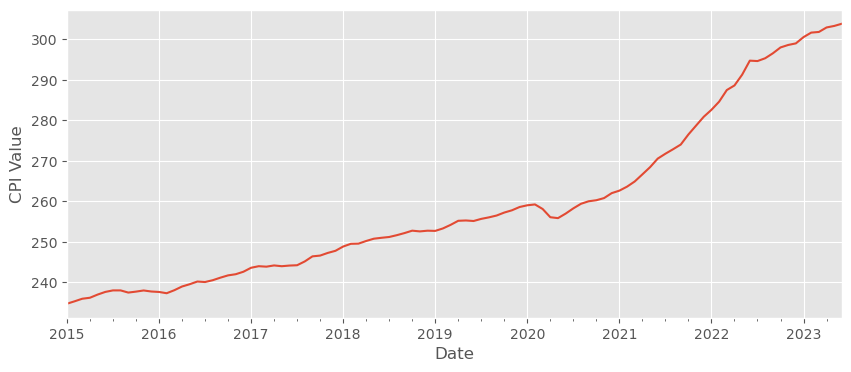

In [69]:
fig = plt.figure(dpi=100)
df_inflat['value'].loc['2015':'2024'].plot(figsize=(10,4))
plt.xlabel('Date')
plt.ylabel('CPI Value')


In [70]:
df_inflat.head()

,date,value,year
dte,,,
2015-01-01,2015-01-01,234.747,2015
2015-02-01,2015-02-01,235.342,2015
2015-03-01,2015-03-01,235.976,2015
2015-04-01,2015-04-01,236.222,2015
2015-05-01,2015-05-01,237.001,2015


In [ ]:
df_inflat = df_inflat.loc["2015-01":"2024-01"]
print(df_inflat)


                 date    value  year
dte                                 
2015-01-01 2015-01-01  234.747  2015
2015-02-01 2015-02-01  235.342  2015
2015-03-01 2015-03-01  235.976  2015
2015-04-01 2015-04-01  236.222  2015
2015-05-01 2015-05-01  237.001  2015
...               ...      ...   ...
2023-02-01 2023-02-01  301.648  2023
2023-03-01 2023-03-01  301.808  2023
2023-04-01 2023-04-01  302.918  2023
2023-05-01 2023-05-01  303.294  2023
2023-06-01 2023-06-01  303.841  2023

[102 rows x 3 columns]


In [73]:
#Targeting a 2% inflation rate since 2015, add a line to same plot to starting with the 2015 value
#df_inflationrates['value'].loc['2015':'2023'].iloc[0]
start = df_inflat['value'].loc['2015':'2024'].iloc[0]

#set the periods to the length of the my date range
periods = get_unique_years(df_inflat).shape[0]

In [74]:
start,periods

(234.747, 9)

In [75]:
#add function that calculates the 2% inflation rate
def get_target_cpi(previous_cpi):
    return previous_cpi + 0.02*(previous_cpi)

In [76]:
target_cpis = [start]
for year in range(0,periods):
    target_cpis.append(get_target_cpi(target_cpis[year]))

In [77]:
target_cpis

[234.747,
 239.44194000000002,
 244.23077880000002,
 249.115394376,
 254.09770226352,
 259.1796563087904,
 264.36324943496624,
 269.6505144236656,
 275.0435247121389,
 280.5443952063817]

In [78]:
len(target_cpis)

10

In [80]:
#Creating a pandas series for the target CPIs starting in 2015:
years = pd.date_range(start=datetime.datetime(2015,1,1),periods=periods+1,freq='YE')
#dates
target_cpi_series = pd.Series(data=target_cpis, index=years)

Text(0, 0.5, 'DFW CPI Value')

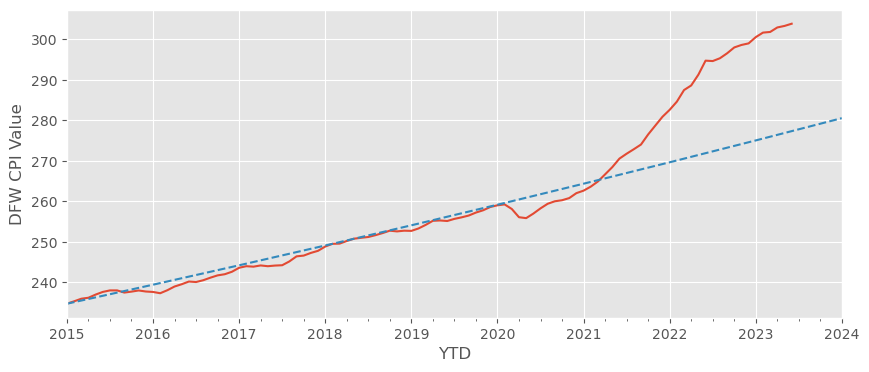

In [81]:
#plot out the figure
fig = plt.figure(dpi=100)
df_inflat['value'].loc['2015':'2023'].plot(figsize=(10,4))
target_cpi_series.plot(ls='--') 
plt.xlabel('YTD')
plt.ylabel('DFW CPI Value')